In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import seaborn as sns
import cv2
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
from transformers import ViTModel, ViTFeatureExtractor

2024-11-01 16:32:20.664720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 16:32:20.676296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 16:32:20.692205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 16:32:20.696440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 16:32:20.709403: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [3]:
# Load dataset and paths
train_csv = pd.read_csv('/home/gcekcse/Documents/ML_Project_hk/data/train.csv')
test_csv = pd.read_csv('/home/gcekcse/Documents/ML_Project_hk/data/test.csv')
base_dir = "/home/gcekcse/Documents/ML_Project_hk/data"
train_path = base_dir + "/train_images/"
test_path = base_dir + "/test_images/"

/tmp/ipykernel_715648/3989213185.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')


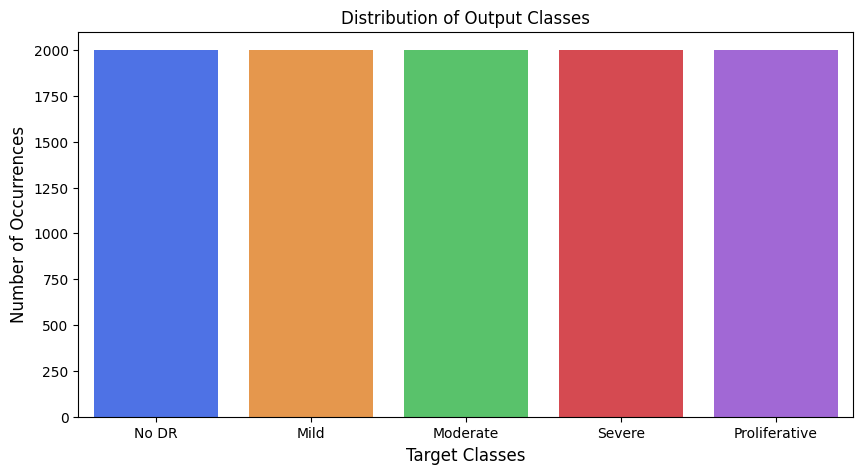

In [4]:
# Check image distribution
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
for i, x in enumerate(class_list):
    counts[x] = counts.pop(i)
plt.figure(figsize=(10, 5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [5]:
# Dataset class
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.png')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# Transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
# Dataset loading
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

# Data loaders
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=64)


In [7]:
# Hybrid Model with ResNet152 and ViT
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        
        # ResNet152 model
        self.resnet = models.resnet152(pretrained=True)
        num_ftrs_resnet = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the ResNet's classifier
        
        # Vision Transformer (ViT) model
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        
        # Combined classifier
        self.fc = nn.Sequential(
            nn.Linear(num_ftrs_resnet + 768, 512),  # Combining ResNet and ViT outputs
            nn.ReLU(),
            nn.Linear(512, 5),  # 5 output classes for diabetic retinopathy
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        resnet_features = self.resnet(x)  # ResNet output
        vit_features = self.vit(pixel_values=x).last_hidden_state[:, 0]  # ViT output (CLS token)
        
        combined = torch.cat((resnet_features, vit_features), dim=1)  # Concatenate ResNet and ViT features
        output = self.fc(combined)  # Classifier
        return output
    
# Initialize the model
model = HybridModel()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device (GPU or CPU)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Train and test loop
def train_and_test(e):
    epochs = e
    train_losses, test_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")
    
    for epoch in range(epochs):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f" epoch {epoch + 1} batch {batch} completed")
        
        test_loss, accuracy = 0, 0
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(validloader))
        acc.append(accuracy)
        scheduler.step()
        
        print(f"Epoch: {epoch + 1}/{epochs}.. "
              f"Training Loss: {running_loss/len(trainloader):.3f}.. "
              f"Valid Loss: {test_loss/len(validloader):.3f}.. "
              f"Valid Accuracy: {accuracy/len(validloader):.3f}")
        
        if test_loss / len(validloader) <= valid_loss_min:
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()},
                       "/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt")
            valid_loss_min = test_loss / len(validloader)
    print('Training Completed Succesfully !')
    return train_losses, test_losses, acc



In [9]:
# Start Training
train_losses, valid_losses, acc = train_and_test(50)

Model Training started.....
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
 epoch 1 batch 40 completed
 epoch 1 batch 50 completed
 epoch 1 batch 60 completed
 epoch 1 batch 70 completed
 epoch 1 batch 80 completed
 epoch 1 batch 90 completed
 epoch 1 batch 100 completed
 epoch 1 batch 110 completed
 epoch 1 batch 120 completed
Epoch: 1/50.. Training Loss: 1.117.. Valid Loss: 0.703.. Valid Accuracy: 0.759
 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
 epoch 2 batch 40 completed
 epoch 2 batch 50 completed
 epoch 2 batch 60 completed
 epoch 2 batch 70 completed
 epoch 2 batch 80 completed
 epoch 2 batch 90 completed
 epoch 2 batch 100 completed
 epoch 2 batch 110 completed
 epoch 2 batch 120 completed
Epoch: 2/50.. Training Loss: 0.542.. Valid Loss: 0.414.. Valid Accuracy: 0.826
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
 epoch 3 batch 40 completed
 epoch 3 batch 50 comple

KeyboardInterrupt: 

In [ ]:

# Function to load checkpoint and continue training
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Checkpoint loaded. Continuing training...")

# Call this function if you want to load the checkpoint and continue training
# Replace the path with your saved model path
checkpoint_path = "/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt"
load_checkpoint(checkpoint_path)

# Now you can call your `train_and_test` function again to continue training
train_and_test(epochs=10)  # Specify additional epochs for continued training


In [ ]:
# Plotting training curves
plt.plot(train_losses, label='train_loss')
plt.plot([x.cpu().numpy() for x in valid_losses], label='valid_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

plt.plot([x.cpu().numpy() for x in acc], label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()


In [ ]:
# Generate Confusion Matrix
def generate_confusion_matrix(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(top_class.cpu().numpy())
    
    cm = confusion_matrix(y_true, [x[0] for x in y_pred])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [ ]:
# Generate confusion matrix for the validation set
generate_confusion_matrix(model, validloader)